# Exploration 11: Stock Closing Price Prediction

---

#### Model
* ARIMA

#### Datasets
* [Alphabet Inc.(GOOG) history stock data](https://finance.yahoo.com/quote/GOOG/history?period1=1580688000&period2=1643760000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)
* [Amazon.com, Inc. (AMZN) history stock data](https://finance.yahoo.com/quote/AMZN/history?p=AMZN)
* [Apple Inc. (AAPL) history stock data](https://finance.yahoo.com/quote/AAPL/history?period1=1581897600&period2=1645056000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)


#### Goals

1. adfuller methods
2. ACF and PACF for p and q, Differencing for d
3. MAPE below 15%
---

## Importing Dependencies

laying the foundation to build my model on

In [13]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

print("All imported!")

All imported!


---

## Loading data - Alphabet Inc.(GOOG)

In [14]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/alphabet.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-02-03 to 2022-02-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       505 non-null    float64
 1   High       505 non-null    float64
 2   Low        505 non-null    float64
 3   Close      505 non-null    float64
 4   Adj Close  505 non-null    float64
 5   Volume     505 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.6 KB


In [15]:
tsA = df['Close']

tsA.head()

Date
2020-02-03    1485.939941
2020-02-04    1447.069946
2020-02-05    1448.229980
2020-02-06    1476.229980
2020-02-07    1479.229980
Name: Close, dtype: float64

## Data pre-processing

#### Missing values

In [16]:
tsA = tsA.interpolate(method='time')
tsA[tsA.isna()]

Series([], Name: Close, dtype: float64)

#### Log transformation

In [17]:
tsA_log = np.log(tsA)
tsA_log

Date
2020-02-03    7.303803
2020-02-04    7.277296
2020-02-05    7.278097
2020-02-06    7.297247
2020-02-07    7.299277
                ...   
2022-01-26    7.857403
2022-01-27    7.856482
2022-01-28    7.888256
2022-01-31    7.906168
2022-02-01    7.922105
Name: Close, Length: 505, dtype: float64

## Stationarity

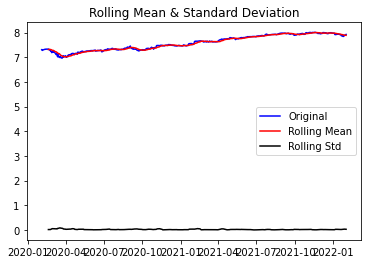

Results of Dickey-Fuller Test:
Test Statistic                  -0.547137
p-value                          0.882485
#Lags Used                       9.000000
Number of Observations Used    495.000000
Critical Value (1%)             -3.443630
Critical Value (5%)             -2.867397
Critical Value (10%)            -2.569889
dtype: float64


In [23]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # visualize
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# qualitative
plot_rolling_statistics(tsA_log, window=12)

# quantitative
augmented_dickey_fuller_test(tsA_log)

p-value is too high

#### Time series decomposition

In [24]:
decomposition = seasonal_decompose(tsA_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.738549e+00
p-value                        3.161616e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.560000e+02
Critical Value (1%)           -3.444772e+00
Critical Value (5%)           -2.867899e+00
Critical Value (10%)          -2.570157e+00
dtype: float64


p-value low enough

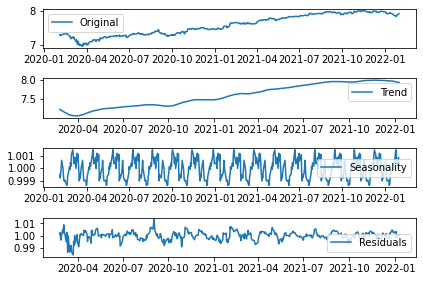

In [25]:
plt.subplot(411)
plt.plot(tsA_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Train and test data

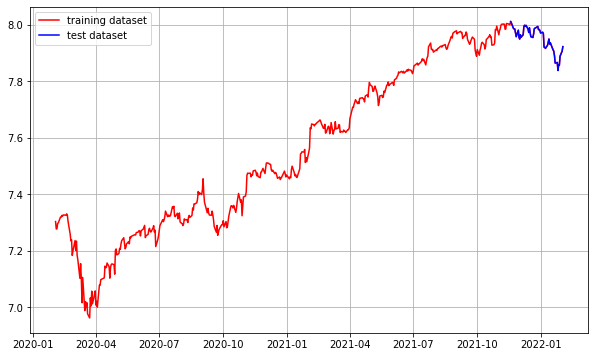

In [26]:
train_data, test_data = tsA_log[:int(len(tsA_log)*0.9)], tsA_log[int(len(tsA_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tsA_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## ARIMA Parameters

#### ACF, PACF for p and q

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


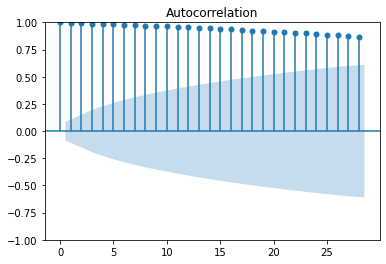

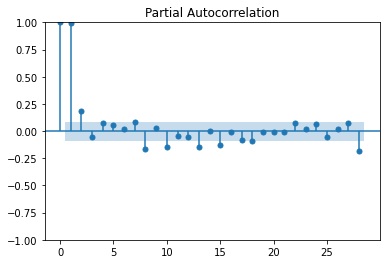

In [27]:
plot_acf(tsA_log)   # ACF : Autocorrelation graph
plot_pacf(tsA_log)  # PACF : Partial Autocorrelation graph
plt.show()

#### degree of differencing

Results of Dickey-Fuller Test:
Test Statistic                -6.532297e+00
p-value                        9.801238e-09
#Lags Used                     8.000000e+00
Number of Observations Used    4.950000e+02
Critical Value (1%)           -3.443630e+00
Critical Value (5%)           -2.867397e+00
Critical Value (10%)          -2.569889e+00
dtype: float64


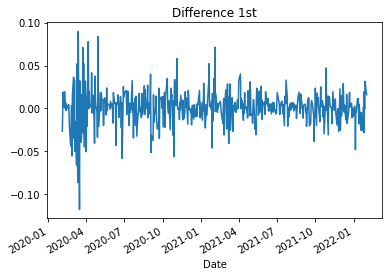

In [28]:
diff_1 = tsA_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.002398e+01
p-value                        1.650552e-17
#Lags Used                     1.400000e+01
Number of Observations Used    4.880000e+02
Critical Value (1%)           -3.443821e+00
Critical Value (5%)           -2.867481e+00
Critical Value (10%)          -2.569934e+00
dtype: float64


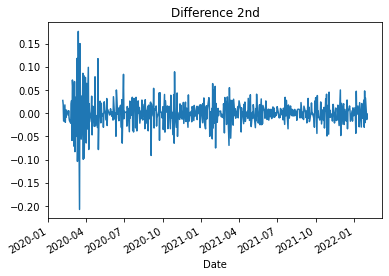

In [29]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


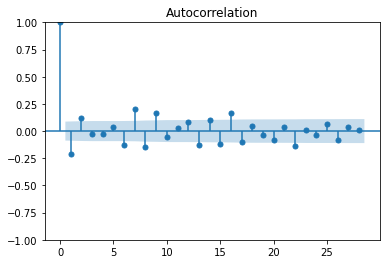

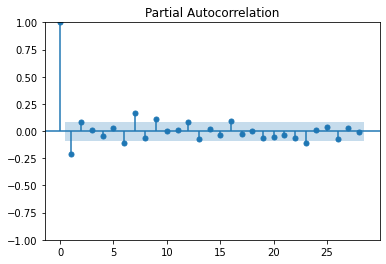

In [30]:
plot_acf(diff_1)
plot_pacf(diff_1)

plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


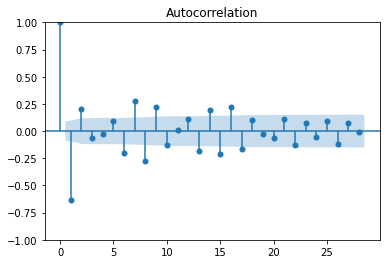

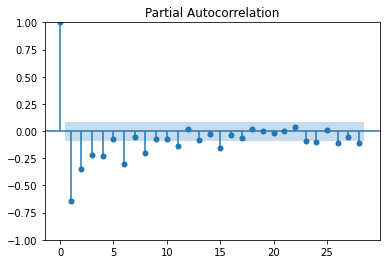

In [31]:
plot_acf(diff_2)
plot_pacf(diff_2)

plt.show()

## ARIMA model train and test

#### Build

In [34]:
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  454
Model:                 ARIMA(1, 0, 0)   Log Likelihood                1112.677
Date:                Thu, 17 Feb 2022   AIC                          -2219.355
Time:                        10:14:01   BIC                          -2207.001
Sample:                             0   HQIC                         -2214.487
                                - 454                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5399      1.474      5.116      0.000       4.651      10.428
ar.L1          0.9995      0.001    775.363      0.000       0.997       1.002
sigma2         0.0004   1.54e-05     27.741      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


#### Forecast

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


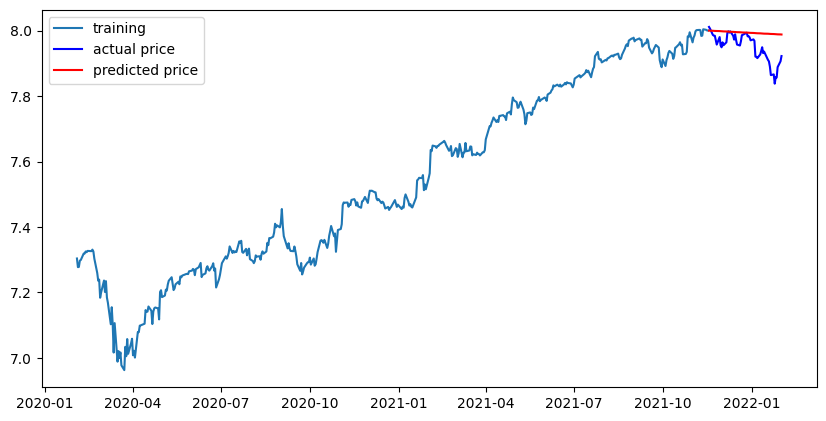

In [35]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # forecast result

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [36]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  28314.534459642546
MAE:  127.65061317460429
RMSE:  168.2692320646961
MAPE: 4.68%


from the graph, I thought p=1, q=0, d=1 would bring the best result but<br/>

* p + q < 2, p * q = 0
* p=1, q=0, d=1 : MAPE 5.33%
* p=1, q=0, d=0 : MAPE 4.68%
* p=2, q=0, d=0 : MAPE 4.84%
* p=2, q=0, d=1 : MAPE 5.32%

### tried with different datasets 

## Loading data - Amazon.com, Inc. (AMZN)

In [37]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMZN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 2020-02-18 to 2022-02-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       506 non-null    float64
 1   High       506 non-null    float64
 2   Low        506 non-null    float64
 3   Close      506 non-null    float64
 4   Adj Close  506 non-null    float64
 5   Volume     506 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.7 KB


In [38]:
tsA = df['Close']

tsA.head()

Date
2020-02-18    2155.669922
2020-02-19    2170.219971
2020-02-20    2153.100098
2020-02-21    2095.969971
2020-02-24    2009.290039
Name: Close, dtype: float64

## Data pre-processing

#### Missing values

In [39]:
tsA = tsA.interpolate(method='time')
tsA[tsA.isna()]

Series([], Name: Close, dtype: float64)

#### Log transformation

In [40]:
tsA_log = np.log(tsA)
tsA_log

Date
2020-02-18    7.675857
2020-02-19    7.682584
2020-02-20    7.674664
2020-02-21    7.647772
2020-02-24    7.605537
                ...   
2022-02-10    8.064659
2022-02-11    8.028087
2022-02-14    8.040234
2022-02-15    8.048855
2022-02-16    8.058963
Name: Close, Length: 506, dtype: float64

## Stationarity

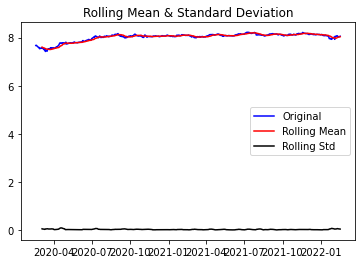

Results of Dickey-Fuller Test:
Test Statistic                  -2.273540
p-value                          0.180644
#Lags Used                       3.000000
Number of Observations Used    502.000000
Critical Value (1%)             -3.443444
Critical Value (5%)             -2.867315
Critical Value (10%)            -2.569846
dtype: float64


In [41]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # visualize
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# qualitative
plot_rolling_statistics(tsA_log, window=12)

# quantitative
augmented_dickey_fuller_test(tsA_log)

In [42]:
decomposition = seasonal_decompose(tsA_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.829601e+00
p-value                        1.908642e-09
#Lags Used                     1.200000e+01
Number of Observations Used    4.630000e+02
Critical Value (1%)           -3.444553e+00
Critical Value (5%)           -2.867803e+00
Critical Value (10%)          -2.570106e+00
dtype: float64


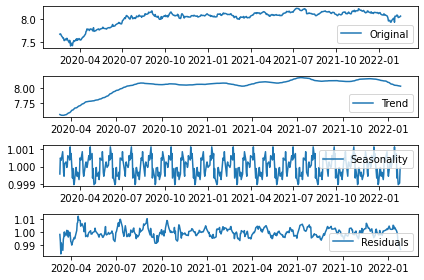

In [43]:
plt.subplot(411)
plt.plot(tsA_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Train and test data

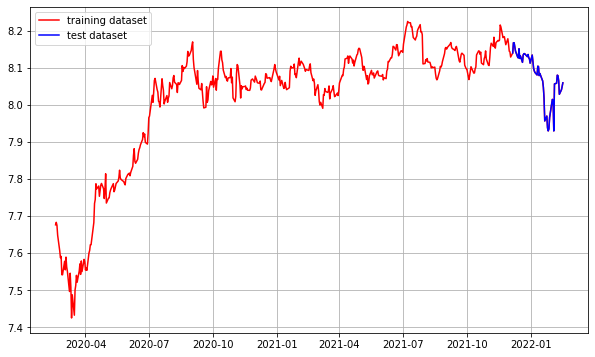

In [44]:
train_data, test_data = tsA_log[:int(len(tsA_log)*0.9)], tsA_log[int(len(tsA_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tsA_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### ARIMA Parameters

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


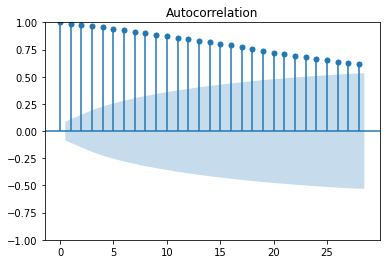

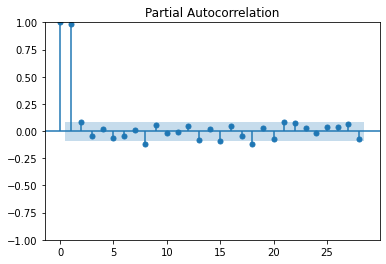

In [45]:
plot_acf(tsA_log)   # ACF : Autocorrelation graph
plot_pacf(tsA_log)  # PACF : Partial Autocorrelation graph
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.390958e+01
p-value                        5.541947e-26
#Lags Used                     2.000000e+00
Number of Observations Used    5.020000e+02
Critical Value (1%)           -3.443444e+00
Critical Value (5%)           -2.867315e+00
Critical Value (10%)          -2.569846e+00
dtype: float64


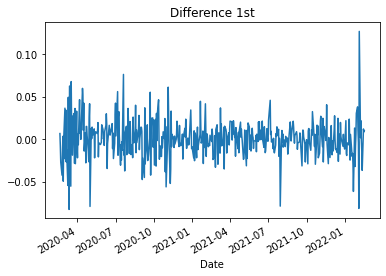

In [46]:
diff_1 = tsA_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


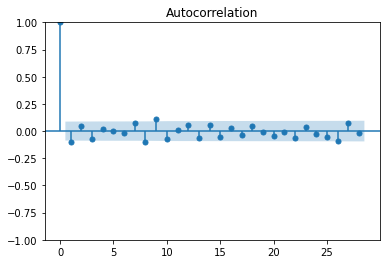

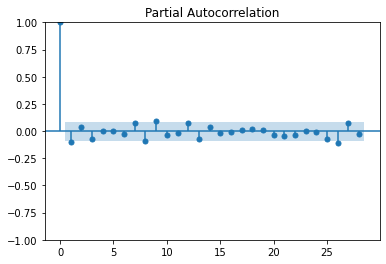

In [47]:
plot_acf(diff_1)
plot_pacf(diff_1)

plt.show()

## ARIMA model train and test

In [48]:
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  455
Model:                 ARIMA(2, 0, 1)   Log Likelihood                1119.416
Date:                Thu, 17 Feb 2022   AIC                          -2228.833
Time:                        10:14:39   BIC                          -2208.231
Sample:                             0   HQIC                         -2220.717
                                - 455                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9724      0.089     89.803      0.000       7.798       8.146
ar.L1          0.3335      0.220      1.513      0.130      -0.098       0.765
ar.L2          0.6547      0.218      2.997      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


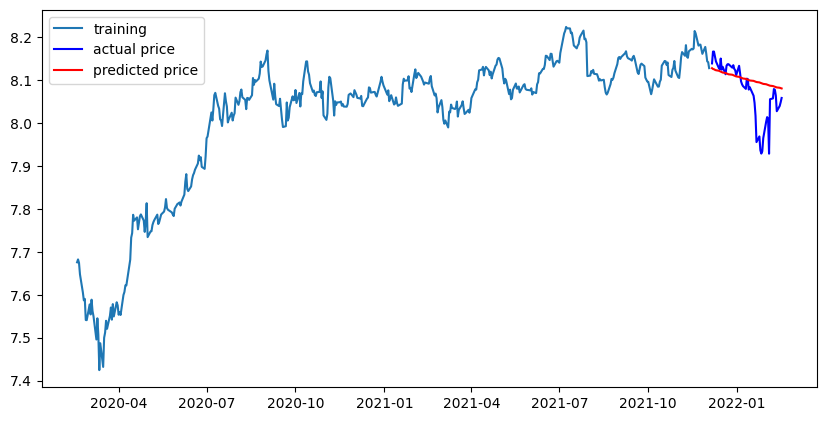

In [49]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # forecast result

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [50]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  37810.24727706864
MAE:  133.99217761411927
RMSE:  194.4485723194404
MAPE: 4.44%


## Loading data - Apple Inc. (AAPL)

In [51]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 506 entries, 2020-02-18 to 2022-02-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       506 non-null    float64
 1   High       506 non-null    float64
 2   Low        506 non-null    float64
 3   Close      506 non-null    float64
 4   Adj Close  506 non-null    float64
 5   Volume     506 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.7 KB


In [52]:
tsA = df['Close']

tsA.head()

Date
2020-02-18    79.750000
2020-02-19    80.904999
2020-02-20    80.074997
2020-02-21    78.262497
2020-02-24    74.544998
Name: Close, dtype: float64

## Data pre-processing

#### Missing values

In [53]:
tsA = tsA.interpolate(method='time')
tsA[tsA.isna()]

Series([], Name: Close, dtype: float64)

#### Log transformation

In [54]:
tsA_log = np.log(tsA)
tsA_log

Date
2020-02-18    4.378897
2020-02-19    4.393276
2020-02-20    4.382964
2020-02-21    4.360069
2020-02-24    4.311403
                ...   
2022-02-10    5.148192
2022-02-11    5.127766
2022-02-14    5.129188
2022-02-15    5.152077
2022-02-16    5.150687
Name: Close, Length: 506, dtype: float64

## Stationarity

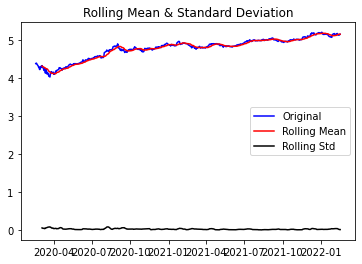

Results of Dickey-Fuller Test:
Test Statistic                  -1.302196
p-value                          0.628167
#Lags Used                       9.000000
Number of Observations Used    496.000000
Critical Value (1%)             -3.443603
Critical Value (5%)             -2.867385
Critical Value (10%)            -2.569883
dtype: float64


In [55]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # visualize
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# qualitative
plot_rolling_statistics(tsA_log, window=12)

# quantitative
augmented_dickey_fuller_test(tsA_log)

In [56]:
decomposition = seasonal_decompose(tsA_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.451795e+00
p-value                        5.645223e-11
#Lags Used                     5.000000e+00
Number of Observations Used    4.700000e+02
Critical Value (1%)           -3.444340e+00
Critical Value (5%)           -2.867709e+00
Critical Value (10%)          -2.570056e+00
dtype: float64


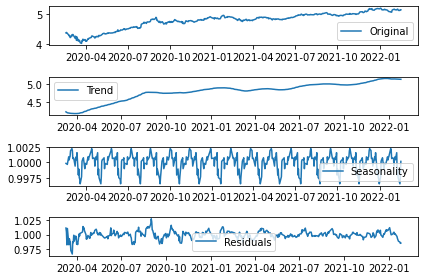

In [57]:
plt.subplot(411)
plt.plot(tsA_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

## Train and test data

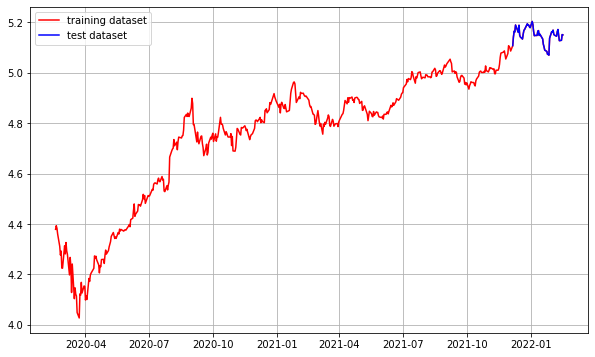

In [58]:
train_data, test_data = tsA_log[:int(len(tsA_log)*0.9)], tsA_log[int(len(tsA_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tsA_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### ARIMA Parameters

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


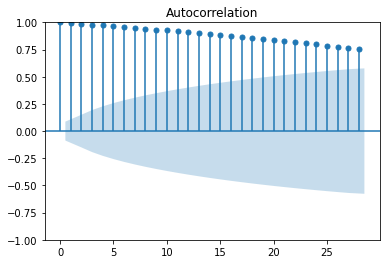

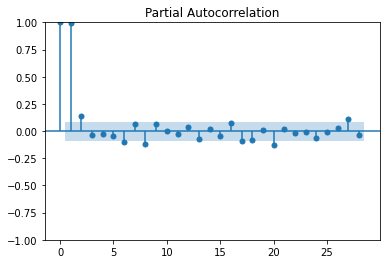

In [59]:
plot_acf(tsA_log)   # ACF : Autocorrelation graph
plot_pacf(tsA_log)  # PACF : Partial Autocorrelation graph
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.248946e+00
p-value                        1.801174e-10
#Lags Used                     8.000000e+00
Number of Observations Used    4.960000e+02
Critical Value (1%)           -3.443603e+00
Critical Value (5%)           -2.867385e+00
Critical Value (10%)          -2.569883e+00
dtype: float64


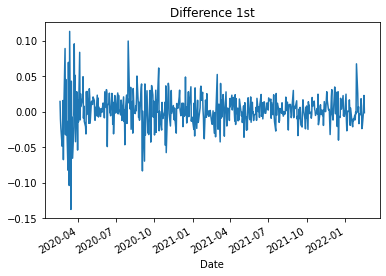

In [60]:
diff_1 = tsA_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


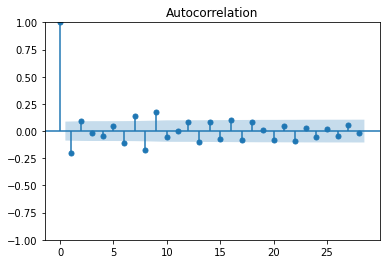

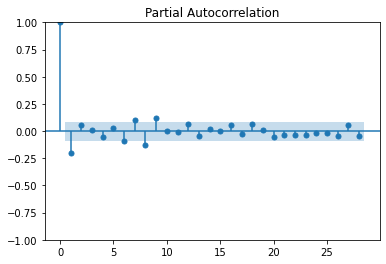

In [61]:
plot_acf(diff_1)
plot_pacf(diff_1)

plt.show()

## ARIMA model train and test

In [62]:
model = ARIMA(train_data, order=(2, 2, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  455
Model:                 ARIMA(2, 2, 1)   Log Likelihood                1051.940
Date:                Thu, 17 Feb 2022   AIC                          -2095.880
Time:                        10:15:05   BIC                          -2079.416
Sample:                             0   HQIC                         -2089.393
                                - 455                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2070      0.032     -6.486      0.000      -0.270      -0.144
ar.L2          0.0534      0.031      1.740      0.082      -0.007       0.114
ma.L1         -0.9997      0.304     -3.291      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


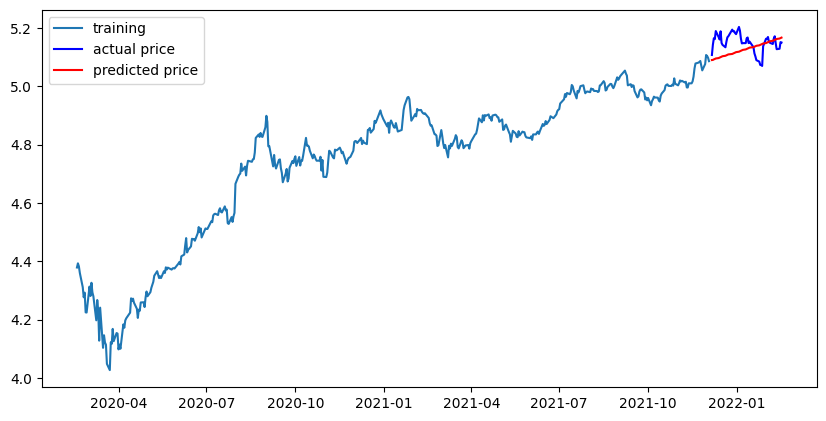

In [63]:
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # forecast result

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [64]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  71.27064916477885
MAE:  7.115026347996412
RMSE:  8.442194570417033
MAPE: 4.11%


---

## Conclusion

Setting the appropriate ARIMA parameters were not easy<br/>
things to remember:
* stationary time series is when the mean and variance are constant over time.
* differencing is a method of transforming a non-stationary time series into a stationary one.
* the autocorrelation function(ACF) plot will let you know how the given time series is correlated with itself
* the partial autocorrelation function(PACF) is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed